In [152]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import time
from sklearn.preprocessing import OneHotEncoder

In [166]:
# Load the digits dataset
digits = load_digits()

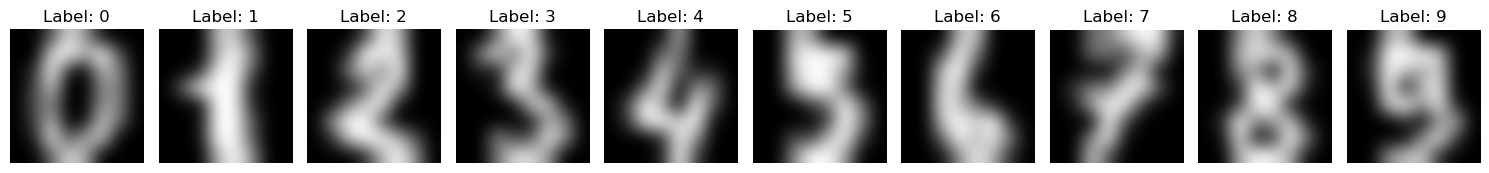

In [167]:
# Show some sample images along with their labels
num_images_to_show = 10

fig, axes = plt.subplots(nrows=1, ncols=num_images_to_show, figsize=(15, 4), dpi=100)

for i in range(num_images_to_show):
    axes[i].imshow(digits.images[i], cmap='gray',interpolation='bicubic')  
    axes[i].set_title(f"Label: {digits.target[i]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [168]:
# Split the dataset into features and labels
X,y = digits.data, digits.target

print(f"Shape of input: {X.shape}")
print(f"shape of target : {y.shape}")


Shape of input: (1797, 64)
shape of target : (1797,)


In [169]:
# set Y label to be one hot encoded with 0-9 as final output label
encoder = OneHotEncoder(categories='auto')
y = encoder.fit_transform(y.reshape(-1,1)).toarray()

print(f"shape of the target variables after one hot encoding: {y.shape}")

shape of the target variables after one hot encoding: (1797, 10)


In [170]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1437, 64)
(1437, 10)
(360, 64)
(360, 10)


In [171]:
# Get the unique labels of train and test
unique_labels_train = np.unique(y_train)
unique_labels_test = np.unique(y_test)

print("Unique labels in training set:", unique_labels_train)
print("Unique labels in testing set:", unique_labels_test)

Unique labels in training set: [0. 1.]
Unique labels in testing set: [0. 1.]


In [172]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [173]:
# Define the softmax function and its derivative
def ReLu(z):
    return np.maximum(0, z)

def softmax(z):
    exp = np.exp(z)
    return exp/np.sum(exp, axis=1, keepdims=True)

def softmax_derivative(output):
    return output * (1 - output)


In [174]:
# Single Hidden Layer Neural Network
class NeuralNetwork:
    # Initialize random weights and biases
    def __init__(self, input_size, hidden_size, output_size):
        self.W1 = np.random.randn(input_size, hidden_size) # dim n_x x n_h
        self.B1 = np.zeros((1, hidden_size)) # dim 1 x n_h
        self.W2 = np.random.randn(hidden_size, output_size) # dim n_h x n_y
        self.B2 = np.zeros((1, output_size)) # dim 1 x n_y

    # Forward Propagation
    def forward_propagation(self, X):
        self.Z1 = np.dot(X, self.W1) + self.B1 # dim m x n_h 
        self.A1 = ReLu(self.Z1)  # ReLU activation in hidden layer
        self.Z2 = np.dot(self.A1, self.W2) + self.B2 # dim m x n_y
        self.A2 = softmax(self.Z2) # dim m x n_y, where n_y is 10 in this dataset
        
        return self.A2
    
    # Compute loss using cateogrical cross entropy function
    def compute_loss(self, X, y):
        # Forward propagation to get predicted probabilities
        output = self.forward_propagation(X)
    
        # Compute categorical cross-entropy loss
        m = y.shape[0]  # Number of samples
        loss = (-1 / m) * np.sum(y * np.log(output + 1e-8)) 
    
        return loss

    # Training process
    def train(self, X, y, learning_rate=0.01, epochs=1000):
        loss_history = []  # Initialize list to store loss values
        fig, ax = plt.subplots()  # Create figure and axis objects for the plot
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.set_title('Training Loss')
        pbar = tqdm(total=epochs, desc='Training')  # Initialize tqdm progress bar

        m = X.shape[0]

        for epoch in range(epochs):
            # Forward propagation
            output = self.forward_propagation(X)
            
            # Backpropagation: calculating gradients
            dZ2 = (self.A2 - y)
            dW2 = np.dot(self.A1.T, dZ2)/m
            dB2 = np.sum(dZ2, axis=0, keepdims=True)/m
            dZ1 = np.multiply(np.dot(dZ2, self.W2.T), np.array(self.A1 > 0, dtype="float32")) # ReLu Derivative
            dW1 = np.dot(X.T, dZ1)/m
            dB1 = np.sum(dZ1, axis=0, keepdims=True)/m

            # Backpropagation: updating weights and biases
            self.W1 = self.W1 - (learning_rate * dW1)
            self.B1 = self.B1 - (learning_rate * dB1)
            self.W2 = self.W2 - (learning_rate * dW2)
            self.B2 = self.B2 - (learning_rate * dB2)
            
            # Record loss for the plot and show progress on progress bar
            
            # Compute loss and append to loss history
            loss = self.compute_loss(X, y)
            loss_history.append(loss)

            # Update progress bar description with current loss
            pbar.set_description('Training (loss: {:.4f})'.format(loss))
            pbar.update(1)  # Update progress bar

        # Plot loss function
        ax.plot(loss_history, color='blue')
        plt.show()  # Show the final plot
        
        pbar.close()  # Close tqdm progress bar after training completes

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Training (loss: 0.2675): 100%|█████████▉| 999/1000 [00:11<00:00, 87.45it/s] 

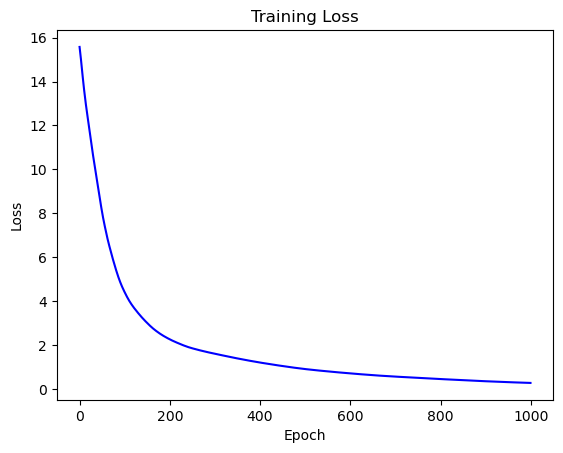

Training (loss: 0.2675): 100%|██████████| 1000/1000 [00:11<00:00, 84.63it/s]


In [180]:
# Initialize the neural network
n_x = X_train.shape[1]
n_h = 100
n_y = 10 
nn_model = NeuralNetwork(n_x, n_h, n_y)
nn_model.train(X_train, y_train)

In [181]:
# Test the neural network
def accuracy(X,y,neural_model):
    # make a prediction
    predictions = neural_model.forward_propagation(X)

    # for each input, classify with the class with highest probability
    predictions = np.argmax(predictions, axis=1)
    labels = np.argmax(y, axis=1)

    # calculate accuracy in percentage
    accuracy = np.round(np.mean(predictions == labels) * 100, 2)

    return accuracy
    

In [182]:
# Accuracy for both training and test data
training_accuracy = accuracy(X_train, y_train,nn_model)

print(f"Accuracy on training data: {training_accuracy}%")

testing_accuracy = accuracy(X_test, y_test,nn_model)

print(f"Accuracy on testing data: {testing_accuracy}%")

Accuracy on training data: 96.8%
Accuracy on testing data: 89.44%
